# UserCF和ItemCF的实现

## 1.读取数据集

In [1]:
import numpy as np

from utils.utils import MovieLensDataset

with open('../dataset/ml-latest-small-ratings.txt', 'r', encoding='utf-8') as f:
    ml_dataset = MovieLensDataset(f)
    print(ml_dataset.data[:10, :])
    print(type(ml_dataset.data))
    print(ml_dataset.data.shape)

[[  1   1   1]
 [  1   3   1]
 [  1   6   1]
 [  1  47   1]
 [  1  50   1]
 [  1  70   0]
 [  1 101   1]
 [  1 110   1]
 [  1 151   1]
 [  1 157   1]]
<class 'numpy.ndarray'>
(100000, 3)


In [2]:
# 进行数据集切分
field_dims, train_set, valid_set, test_set = ml_dataset.train_valid_test_split(train_size=0.8, valid_size=0.1, test_size=0.1)
field_dims = [field_dims[0] - 1, field_dims[1] - 1]
user_num, item_num = field_dims[0], field_dims[1]
print(f'train_set shape: {train_set[0].shape}')
print(f'valid_set shape: {valid_set[0].shape}')
print(f'test_set shape: {test_set[0].shape}')
print(f'field_dims: {field_dims}')


train_set shape: torch.Size([80000, 2])
valid_set shape: torch.Size([10000, 2])
test_set shape: torch.Size([10000, 2])
field_dims: [610, 193609]


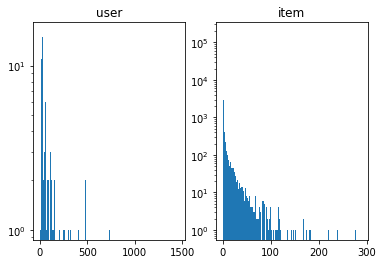

In [3]:
# 数据分析与展示
import matplotlib.pyplot as plt
user_cnt = np.zeros(field_dims[0])  # 统计每个用户喜欢的物品数量
item_cnt = np.zeros(field_dims[1])  # 统计喜欢每个物品的用户数量
for i in range(ml_dataset.data.shape[0]):
    if ml_dataset.data[i, 2] == 1:
        user_cnt[ml_dataset.data[i, 0] - 1] += 1
        item_cnt[ml_dataset.data[i, 1] - 1] += 1
fig, ax = plt.subplots(1, 2)
# 经过log处理
ax[0].hist(user_cnt, range(int(np.max(user_cnt))), log=True)
ax[0].set_title('user')
ax[1].hist(item_cnt, range(int(np.max(item_cnt))), log=True)
ax[1].set_title('item')

plt.show()

## 2.UserCF

### 2.1 建立倒排表

In [4]:
# 倒排表就是从用户->物品表，针对每个物品，将喜欢该物品的用户放在一个列表内
def create_reverse_table(train_set):
    log_num = train_set[0].shape[0]
    table = dict()
    reverse_table = dict()
    for i in range(log_num):
        user = train_set[0][i, 0].item()
        item = train_set[0][i, 1].item()
        if train_set[1][i] == 1:
            if item not in reverse_table.keys():
                reverse_table[item] = [user]
            else:
                if user in reverse_table[item]:
                    raise ValueError
                reverse_table[item].append(user)

            if user not in table.keys():
                table[user] = [item]
            else:
                if item in table[user]:
                    raise ValueError
                table[user].append(item)

    print(f'length of reverse_table: {len(reverse_table)}')
    print(f'length of table: {len(table)}')

    return table, reverse_table
table, reverse_table = create_reverse_table(train_set)

length of reverse_table: 6577
length of table: 609


### 2.2 建立用户相似度矩阵

In [5]:
# 建立用户相似度矩阵（余弦相似度）
def create_sim_matrix(reverse_table):
    user_co_occurrence_cnt_dict = dict()
    user_item_behavior_cnt_dict = dict()
    for item, users in reverse_table.items():
        for user in users:
            if user not in user_item_behavior_cnt_dict.keys():
                user_item_behavior_cnt_dict[user] = 0
            user_item_behavior_cnt_dict[user] += 1

            for user_2 in users:
                if user == user_2:
                    continue
                else:
                    if (user, user_2) not in user_co_occurrence_cnt_dict.keys():
                        user_co_occurrence_cnt_dict[user, user_2] = 0
                    user_co_occurrence_cnt_dict[user, user_2] += 1

    sim_Matrix = dict()
    for co_user, cnt_of_co in user_co_occurrence_cnt_dict.items():
        user_cnt_1 = user_item_behavior_cnt_dict[co_user[0]]
        user_cnt_2 = user_item_behavior_cnt_dict[co_user[1]]
        sim_Matrix[co_user] = cnt_of_co / np.sqrt(user_cnt_1 * user_cnt_2)

    return sim_Matrix

sim_Matrix = create_sim_matrix(reverse_table)
cnt = 0
for co_user, sim in sim_Matrix.items():
    print(f'{co_user[0]}--{co_user[1]}: {sim}')
    cnt += 1
    if cnt > 100:
        break

380--213: 0.11736423142759768
380--608: 0.23056449071586882
380--166: 0.2335828649895135
380--560: 0.225773816165526
380--534: 0.2891520357449769
380--68: 0.2537988035582843
380--122: 0.2280174143549268
380--249: 0.3418855702935182
213--380: 0.11736423142759768
213--608: 0.07903245177007728
213--166: 0.13511320473331348
213--560: 0.10407662860836864
213--534: 0.11847337159290512
213--68: 0.10517507230687265
213--122: 0.07034343285955469
213--249: 0.13442482936595765
608--380: 0.23056449071586882
608--213: 0.07903245177007728
608--166: 0.25805958938416595
608--560: 0.2402055972207552
608--534: 0.18586283791550756
608--68: 0.25566446930151254
608--122: 0.17954380100002953
608--249: 0.24992223643185837
166--380: 0.2335828649895135
166--213: 0.13511320473331348
166--608: 0.25805958938416595
166--560: 0.2457266521549293
166--534: 0.20024839587300075
166--68: 0.2403949865600188
166--122: 0.19523470984497385
166--249: 0.2532281323315085
560--380: 0.225773816165526
560--213: 0.1040766286083686

### 2.3 进行协同过滤，生成推荐列表

In [6]:
# 生成目标用户的推荐列表
def dict2ndarray(sim_Matrix: dict, n: int) -> np.ndarray:
    """
    将dict形式的相似度矩阵转为ndarray形式，方便使用numpy的max函数筛选
    :param sim_Matrix: dict形式的相似度矩阵
    :param n: 用户的数量，确实相似度矩阵的维度
    :return: ndarray形式的相似度矩阵
    """
    sim_Matrix_np = np.zeros((n, n))
    for co_user, sim in sim_Matrix.items():
        sim_Matrix_np[co_user[0] - 1, co_user[1] - 1] = sim

    return sim_Matrix_np

def create_rec_list(u: int, sim_Matrix_np: np.ndarray, k: int, n=-1) -> (list, list):
    """
    生成推荐列表
    :param u: 目标用户
    :param sim_Matrix_np: 用户相似度矩阵
    :param k: 根据与目标用户最相近的n个用户进行推荐
    :param n: 推荐列表的长度
    :return: 推荐列表
    """
    u -= 1
    top_k_id = sim_Matrix_np[u, :].argsort()[::-1][0:k]

    rec_dict = dict()
    for v in top_k_id:
        v_item_list = table[v + 1]
        for it in v_item_list:
            if it not in rec_dict.keys():
                rec_dict[it] = 0
            rec_dict[it] += sim_Matrix_np[u, v]


    rec_list = sorted(rec_dict.items(), key=lambda x: x[1], reverse=True)
    rec_list_wo_sim = [idx for idx, sim in rec_list]

    if n != -1:
        return rec_list[:n], rec_list_wo_sim[:n]
    else:
        return rec_list, rec_list_wo_sim


sim_Matrix_np = dict2ndarray(sim_Matrix, n=user_num)
print(sim_Matrix_np)
rec_list, rec_list_wo_sim = create_rec_list(1, sim_Matrix_np, k=3)
print(rec_list[:10])
print(rec_list_wo_sim[:10])

[[0.         0.01860807 0.02167775 ... 0.12870724 0.05407381 0.15914294]
 [0.01860807 0.         0.         ... 0.03765921 0.         0.01406638]
 [0.02167775 0.         0.         ... 0.         0.         0.03277368]
 ...
 [0.12870724 0.03765921 0.         ... 0.         0.03647838 0.26839594]
 [0.05407381 0.         0.         ... 0.03647838 0.         0.04087596]
 [0.15914294 0.01406638 0.03277368 ... 0.26839594 0.04087596 0.        ]]
[(1291, 0.7733822666033682), (924, 0.7733822666033682), (1198, 0.7733822666033682), (50, 0.7733822666033682), (2947, 0.7733822666033682), (1196, 0.7733822666033682), (260, 0.7733822666033682), (1206, 0.7733822666033682), (1242, 0.5347754804874515), (110, 0.5347754804874515)]
[1291, 924, 1198, 50, 2947, 1196, 260, 1206, 1242, 110]


In [7]:
# print(sorted(table.items(), key=lambda d: d[0]))
def pad_missing_user(table, item_num, user_num):
    print(len(table.keys()))
    print(item_num)
    print(user_num)
    missing_user = []
    for i in range(1, user_num):
        if i not in table.keys():
            # print(f'missing user: {i}')
            missing_user.append(i)
            table[i] = []
    return table
    # print(sorted(table.items(), key=lambda d: d[0]))

In [8]:
print([x[1] for x in sorted(table.items(), key=lambda d: d[0])])

[[2353, 923, 2944, 661, 1097, 3052, 1270, 1282, 590, 1136, 2459, 527, 2872, 1198, 2048, 2161, 2529, 3448, 2268, 2054, 2005, 457, 1348, 608, 2012, 1208, 2761, 2692, 1042, 1092, 1620, 2959, 553, 349, 2947, 543, 2028, 3740, 2991, 2478, 2366, 2949, 362, 2387, 1920, 47, 2143, 3671, 3578, 1617, 235, 231, 1552, 2096, 3053, 2115, 1049, 2139, 919, 5060, 733, 2580, 367, 1127, 2797, 1080, 216, 2648, 6, 1197, 1024, 1224, 3639, 2395, 3617, 3702, 2596, 2640, 2273, 3386, 3440, 3703, 592, 2141, 2654, 1206, 2094, 1031, 1032, 2078, 1240, 1089, 3441, 3793, 480, 940, 596, 2174, 1793, 3744, 1275, 804, 2716, 1777, 3489, 1256, 1, 2090, 2291, 110, 1473, 1210, 3729, 3479, 3062, 2033, 1278, 2105, 1073, 1214, 1298, 2987, 1805, 1226, 2450, 2700, 3809, 2542, 2137, 2502, 1060, 1573, 954, 2571, 2018, 2058, 1196, 1222, 2406, 157, 2046, 2948, 1500, 943, 3253, 2641, 3033, 333, 1927, 1025, 2644, 260], [112552, 80906, 74458, 48516, 58559, 8798, 115713, 6874, 1704, 106782, 122882, 99114, 86345, 333, 46970, 80489, 89774, 1

In [16]:
from utils.utils import Metric

# 看训练集表现

metric = Metric(k=(1, 10, 50))

table = pad_missing_user(table, item_num=item_num, user_num=user_num)
label = [x[1] for x in sorted(table.items(), key=lambda d: d[0])]

def evaluate(sim_Matrix, label, n_items, n_users, k=10, n=50):
    sim_Matrix_np = dict2ndarray(sim_Matrix, n_users)
    array_pred = np.zeros((n_users, n), dtype=np.int32)
    for u in range(1, user_num + 1):
        temp_lst = create_rec_list(u, sim_Matrix_np, k, n)[1]
        array_pred[u - 1, :len(temp_lst)] = temp_lst
    print(f'length of label: {len(label)}')
    print(f'length of array_pred: {len(array_pred)}')
    assert len(label) == len(array_pred)
    print(array_pred.shape)
    metric.compute_metric(label=label, pred=array_pred, n_items=n_items, n_users=n_users)
    print(metric)

evaluate(sim_Matrix, label, n_items=item_num, n_users=user_num)



610
193609
610
length of label: 610
length of array_pred: 610
(610, 50)
hit:
	hit@1: 0.8785
	hit@10: 1.0000
	hit@50: 1.0000
gini_index:
	gini_index@1: 0.6103
	gini_index@10: 0.7488
	gini_index@50: 0.7804
diversity:
	diversity@1: 0.9740
	diversity@10: 0.8540
	diversity@50: 0.7413
nDCG:
	nDCG@1: 0.8785
	nDCG@10: 0.9105
	nDCG@50: 0.8654
MRR:
	MRR@1: 0.8785
	MRR@10: 0.9318
	MRR@50: 0.9318



In [21]:
# 看验证集、测试集表现
def pred(data_set, sim_Matrix, item_num, user_num):
    ## 确定验证集中没有陌生值
    table, _ = create_reverse_table(data_set)
    # print(len(valid_table))
    # print(len(valid_reverse_table))
    # print(len(set(table.keys()) - set(table.keys()) & set(valid_table.keys())))
    # print(len(set(reverse_table.keys()) - set(reverse_table.keys()) & set(valid_reverse_table.keys())))

    ## 验证集
    table = pad_missing_user(table, item_num=item_num, user_num=user_num)
    label = [x[1] for x in sorted(table.items(), key=lambda d: d[0])]
    evaluate(sim_Matrix, label, n_items=item_num, n_users=user_num)

print("Valid")
pred(valid_set, sim_Matrix, item_num=item_num, user_num=user_num)
print("Test")
pred(test_set, sim_Matrix, item_num=item_num, user_num=user_num)

Valid
length of reverse_table: 2533
length of table: 566
566
193609
610
missing user: 26
missing user: 36
missing user: 46
missing user: 54
missing user: 56
missing user: 106
missing user: 120
missing user: 127
missing user: 134
missing user: 138
missing user: 145
missing user: 148
missing user: 149
missing user: 163
missing user: 173
missing user: 206
missing user: 214
missing user: 245
missing user: 255
missing user: 258
missing user: 270
missing user: 272
missing user: 311
missing user: 324
missing user: 333
missing user: 340
missing user: 355
missing user: 394
missing user: 395
missing user: 406
missing user: 407
missing user: 441
missing user: 442
missing user: 472
missing user: 481
missing user: 507
missing user: 521
missing user: 529
missing user: 531
missing user: 548
missing user: 549
missing user: 576
missing user: 578
missing user: 589
length of label: 610
length of array_pred: 610
(610, 50)
hit:
	hit@1: 0.0124
	hit@10: 0.2792
	hit@50: 0.7297
gini_index:
	gini_index@1: 0.607